In [1]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
%pylab inline 
import statsmodels.formula.api as smf
import community as cmnt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Reading rides data for June, 2014 and stations location
allrides = pd.read_csv('2014-06 - Citi Bike trip data.csv')
stations = pd.read_csv( 'citibike-locations.csv')

In [3]:
stations.head()

,the_geom,objectid,station_id,lat,lon,borough,name,cartodb_id,created_at,updated_at
0,0101000020E6100000899FCD819C7F52C097C807B43562...,1,72,40.767272,-73.993929,Manhattan,72,1,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
1,0101000020E61000009C8FB6336D8052C0078EEFB40B5C...,2,79,40.719116,-74.006667,Manhattan,79,2,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
2,0101000020E61000006C89E1AF028052C0A517FD7B075B...,3,82,40.711174,-74.000165,Manhattan,82,3,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
3,0101000020E61000003F96B982188052C0D584083FF25E...,4,116,40.741776,-74.001497,Manhattan,116,4,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
4,0101000020E61000005CA5D0796E8052C0067ADCDEA85D...,5,127,40.731724,-74.006744,Manhattan,127,5,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00


In [4]:
# Converting starttime, stoptime into datetime format
allrides['starttime'] = pd.to_datetime(allrides['starttime'])
allrides['stoptime']  = pd.to_datetime(allrides['stoptime'])

# Calculating ride duration
allrides['duration'] = allrides['stoptime'] - allrides['starttime']
allrides['duration'] = pd.to_datetime(allrides['duration'])
print len(allrides)

936880


In [5]:
allrides.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration
0,520,2014-06-01 00:00:02,2014-06-01 00:08:42,358,Christopher St & Greenwich St,40.732916,-74.007114,426,West St & Chambers St,40.717548,-74.013221,18840,Subscriber,1979,1,1970-01-01 00:08:40
1,520,2014-06-01 00:00:27,2014-06-01 00:09:07,335,Washington Pl & Broadway,40.729039,-73.994046,265,Stanton St & Chrystie St,40.722293,-73.991475,17442,Customer,\N,0,1970-01-01 00:08:40
2,414,2014-06-01 00:00:32,2014-06-01 00:07:26,439,E 4 St & 2 Ave,40.726281,-73.989780,368,Carmine St & 6 Ave,40.730386,-74.002150,16447,Subscriber,1980,1,1970-01-01 00:06:54
3,310,2014-06-01 00:00:34,2014-06-01 00:05:44,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,18218,Subscriber,1984,1,1970-01-01 00:05:10
4,457,2014-06-01 00:00:35,2014-06-01 00:08:12,352,W 56 St & 6 Ave,40.763406,-73.977225,305,E 58 St & 3 Ave,40.760958,-73.967245,18115,Subscriber,1969,1,1970-01-01 00:07:37


In [6]:
stations_name = allrides.groupby(['start station id', 'start station name']).count()
stations_name = stations_name.reset_index()

In [7]:
stations_name = stations_name[['start station id', 'start station name', 'tripduration']]
stations_name.columns = ['id', 'name', 'count']
stations_name.head()
# print len(stations_name)
# print stations_name

,id,name,count
0,72,W 52 St & 11 Ave,3088
1,79,Franklin St & W Broadway,2357
2,82,St James Pl & Pearl St,1191
3,83,Atlantic Ave & Fort Greene Pl,1270
4,116,W 17 St & 8 Ave,5168


In [8]:
station_name = allrides.groupby(['end station id', 'end station name']).count()
station_name = station_name.reset_index()

In [9]:
station_name = station_name[['end station id', 'end station name', 'tripduration']]
station_name.columns = ['id', 'name', 'count']
station_name.head()
# print len(station_name)
# print station_name

,id,name,count
0,72,W 52 St & 11 Ave,3156
1,79,Franklin St & W Broadway,2483
2,82,St James Pl & Pearl St,1196
3,83,Atlantic Ave & Fort Greene Pl,1584
4,116,W 17 St & 8 Ave,5156


In [10]:
# Reading descriptive statistics
allrides['duration'].describe()

count                  936880
unique                   9060
top       1970-01-01 00:07:29
freq                     1101
first     1970-01-01 00:01:00
last      1970-01-01 05:59:36
Name: duration, dtype: object

In [11]:
# Cleaning the data, removing lower 25%, longer than 7 minutes
allrides = allrides[allrides['duration'] > '1970-01-01 00:07:00']
print len(allrides)

699372


In [12]:
# function to calculate if a given date is a weekday, or a weekend
def Weekend(x):
    if x.weekday() > 4:
        return True
    return False

# checking if a start time of the trip is a weekend
allrides['weekEnd'] = allrides['starttime'].apply(lambda x: Weekend(x))
allrides.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration,weekEnd
0,520,2014-06-01 00:00:02,2014-06-01 00:08:42,358,Christopher St & Greenwich St,40.732916,-74.007114,426,West St & Chambers St,40.717548,-74.013221,18840,Subscriber,1979,1,1970-01-01 00:08:40,True
1,520,2014-06-01 00:00:27,2014-06-01 00:09:07,335,Washington Pl & Broadway,40.729039,-73.994046,265,Stanton St & Chrystie St,40.722293,-73.991475,17442,Customer,\N,0,1970-01-01 00:08:40,True
4,457,2014-06-01 00:00:35,2014-06-01 00:08:12,352,W 56 St & 6 Ave,40.763406,-73.977225,305,E 58 St & 3 Ave,40.760958,-73.967245,18115,Subscriber,1969,1,1970-01-01 00:07:37,True
6,1280,2014-06-01 00:00:45,2014-06-01 00:22:05,168,W 18 St & 6 Ave,40.739713,-73.994564,341,Stanton St & Mangin St,40.717821,-73.976289,18766,Subscriber,1989,1,1970-01-01 00:21:20,True
7,973,2014-06-01 00:00:52,2014-06-01 00:17:05,453,W 22 St & 8 Ave,40.744751,-73.999154,447,8 Ave & W 52 St,40.763707,-73.985162,21391,Customer,\N,0,1970-01-01 00:16:13,True


In [13]:
# Splitting the data into weekday and weekend datasets
weekend = allrides[allrides['weekEnd'] == True]
weekday = allrides[allrides['weekEnd'] == False]
print len(weekend)
print len(weekday)

207460
491912


In [14]:
# Counting rides between each pair of the stations
weekday_grouped = weekday.groupby(['start station id', 'end station id']).count()
weekend_grouped = weekend.groupby(['start station id', 'end station id']).count()

In [15]:
# Resetting the indeces
weekday_grouped = weekday_grouped.reset_index()
weekend_grouped = weekend_grouped.reset_index()

In [16]:
# Selecting 3 columns, representing node A, node B and weight of the edges
weekday_grouped = weekday_grouped[['start station id', 'end station id', 'tripduration']]
weekend_grouped = weekend_grouped[['start station id', 'end station id', 'tripduration']]
weekday_grouped.columns = ['start', 'stop', 'weight']
weekend_grouped.columns = ['start', 'stop', 'weight']

In [17]:
# Taking a look at the resulting dataframes
print weekday_grouped.head()
print weekend_grouped.head()

   start  stop  weight
0     72    72      23
1     72    79      10
2     72    82       2
3     72    83       1
4     72   116       1
   start  stop  weight
0     72    72      45
1     72   116       4
2     72   127       3
3     72   128       4
4     72   137       3


In [18]:
# Creating the graphs
weekday_graph = nx.DiGraph()
weekend_graph = nx.DiGraph()

# There are 9 weekends and 21 weekday in June, 2014
# Adding edges
for k in weekday_grouped.index:
    weekday_graph.add_edge(weekday_grouped['start'][k], weekday_grouped['stop'][k], weight = 1.0*weekday_grouped['weight'][k]/21)
for k in weekend_grouped.index:
    weekend_graph.add_edge(weekend_grouped['start'][k], weekend_grouped['stop'][k], weight = 1.0*weekend_grouped['weight'][k]/9)

In [19]:
print stations_name.head()
print stations_name.name[stations_name.id ==79][1]

    id                           name  count
0   72               W 52 St & 11 Ave   3088
1   79       Franklin St & W Broadway   2357
2   82         St James Pl & Pearl St   1191
3   83  Atlantic Ave & Fort Greene Pl   1270
4  116                W 17 St & 8 Ave   5168
Franklin St & W Broadway


In [20]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1}:{2} {3}'.format(i+1,ind[i],d[ind[i]], stations_name[stations_name['id']==ind[i]]['name'].values[0]))
#              #, stations_name.name[stations_name.id == ind[i]][1]))

In [21]:
# Pagerank for various alphas
#alpha = [0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#for al in alpha:
print "Week Day as a whole"
topdict(nx.pagerank(weekday_graph, 0.85), 10)
print "Week End as a whole"
topdict(nx.pagerank(weekend_graph, 0.85), 10)
#print "\n"

Week Day as a whole
1|519:0.0102330463158 E 42 St & Vanderbilt Ave
2|521:0.00943476215968 8 Ave & W 31 St
3|426:0.00882589233775 West St & Chambers St
4|358:0.0087043448856 Christopher St & Greenwich St
5|497:0.00856936546949 E 17 St & Broadway
6|293:0.00790108007625 Lafayette St & E 8 St
7|151:0.00713357026801 Cleveland Pl & Spring St
8|347:0.00711436862961 W Houston St & Hudson St
9|435:0.00694221751612 W 21 St & 6 Ave
10|402:0.00690363810497 Broadway & E 22 St
Week End as a whole
1|426:0.0117717581092 West St & Chambers St
2|497:0.00926656667004 E 17 St & Broadway
3|499:0.00919804266312 Broadway & W 60 St
4|327:0.00861030004448 Vesey Pl & River Terrace
5|2006:0.00810888276085 Central Park S & 6 Ave
6|514:0.00807308867775 12 Ave & W 40 St
7|387:0.00792758862587 Centre St & Chambers St
8|151:0.00790837662222 Cleveland Pl & Spring St
9|368:0.007678495869 Carmine St & 6 Ave
10|358:0.00759558128304 Christopher St & Greenwich St


In [22]:
# Function that removes loops from the graph
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU  

In [23]:
# Function that creates undirected symmetrical graph
def directed_to_undirected(G):
    GU=nx.Graph()
    for e in G.edges(data=True):
        if GU.has_edge(e[0],e[1]):
            GU[e[0]][e[1]]['weight']=GU[e[0]][e[1]]['weight']+e[2]['weight']
        else:
            GU.add_edge(e[0],e[1],weight=e[2]['weight'])
    return GU   

In [24]:
weekday_graph = remove_loops(weekday_graph)
weekend_graph = remove_loops(weekend_graph)
weekday_graph = directed_to_undirected(weekday_graph)
weekend_graph = directed_to_undirected(weekend_graph)
weekday_communities = cmnt.best_partition(weekday_graph)
weekend_communities = cmnt.best_partition(weekend_graph)

In [25]:
# Pageranks
weekday_pagerank = nx.pagerank(weekday_graph, 0.85)
weekend_pagerank = nx.pagerank(weekend_graph, 0.85)

In [26]:
# Calculating locations of the stations
pos ={}
for c in stations.index:
    pos[stations.station_id[c]] = (stations.lon[c], stations.lat[c])

In [27]:
# Visualizing function
def visualizePartition(G, partition, pgrank, pos):
    labels = {}   
    N=len(G.nodes())
    s=4+4*int(log10(N))
    plt.figure(figsize=(s,s))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
        if 1.5E5*pgrank[n] > 1000:
            #set the node name as the key and the label as its value 
            labels[n] = n
    n_size = 1.5E5*np.array(pgrank.values())
    for i in range(0, len(n_size)):
        if n_size[i] <1000:
            n_size[i] = 100
            
    nx.draw(G, pos=pos, with_labels=False, arrows=True, node_size=n_size, 
            node_color=c, width=0.5, style='dotted',edge_color='green')
#     nx.draw_networkx_labels(G,pos,labels)
#     print(1.5E5*np.array(pgrank.values()))
#     mplleaflet.display()

/home/bibby/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


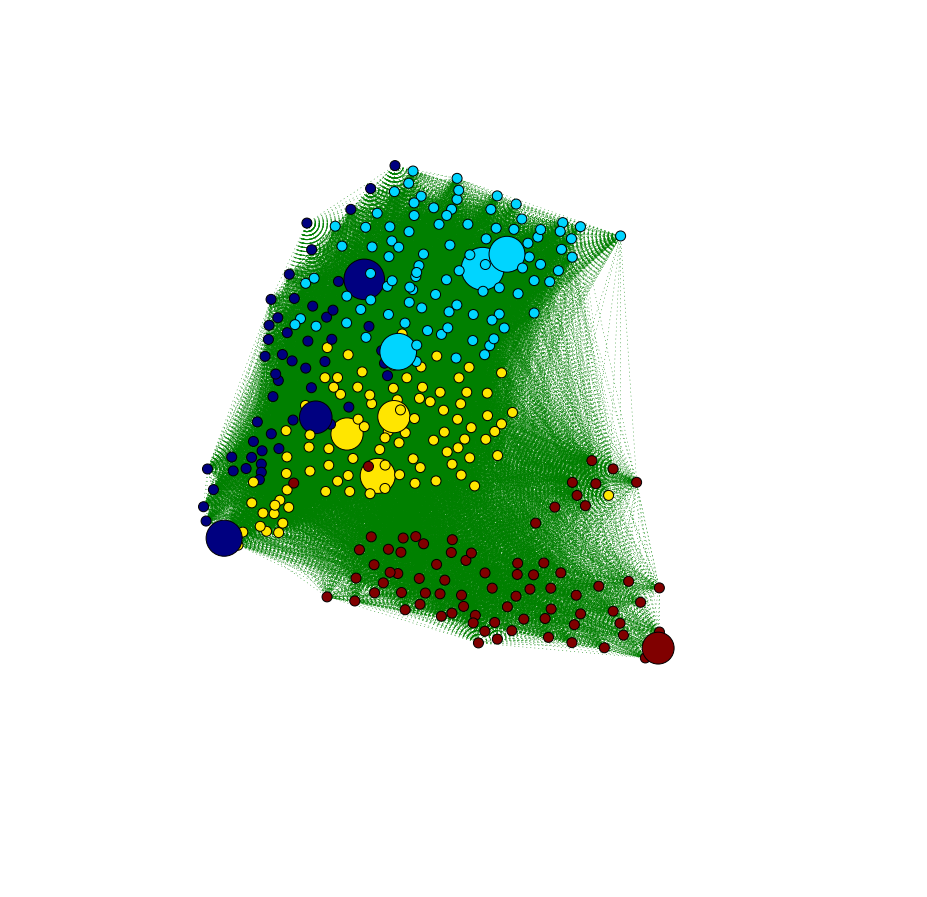

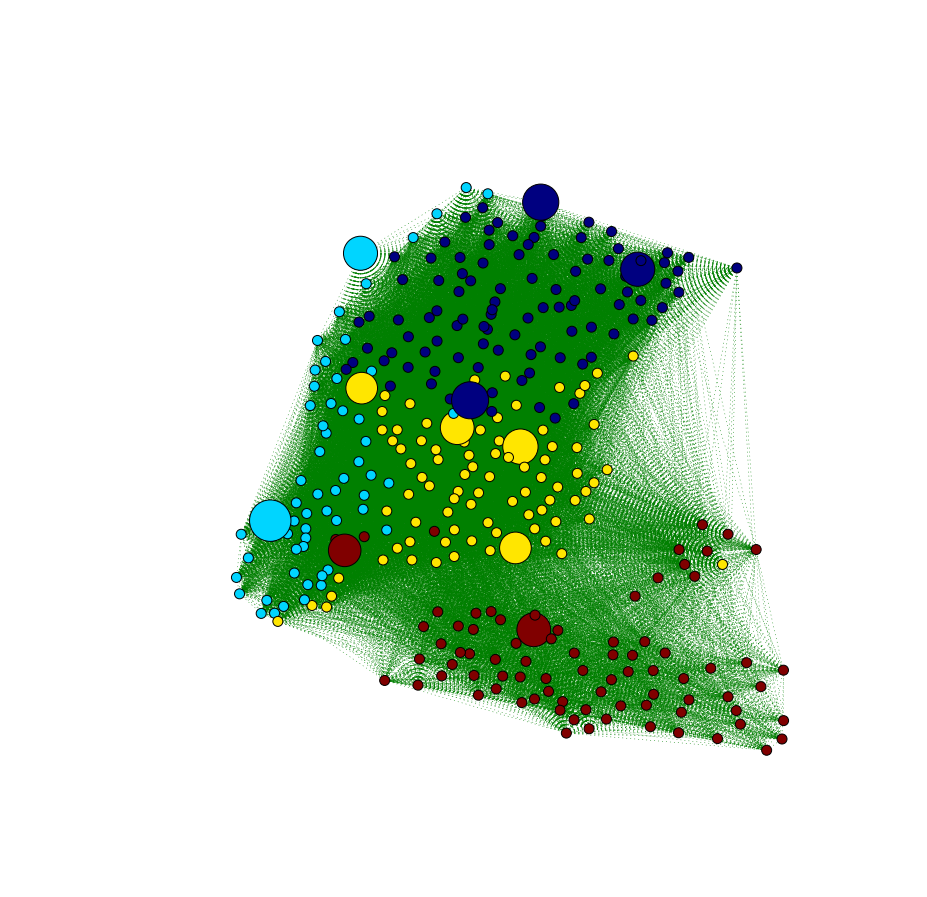

In [28]:
# Plotting the communities
random.seed(2015)
visualizePartition(weekday_graph, weekday_communities, weekday_pagerank, pos)
random.seed(2015)
visualizePartition(weekend_graph, weekend_communities, weekend_pagerank, pos)

In [29]:
print unique(weekday_communities.values())

[0 1 2 3]


In [30]:
# Splitting the graphs into communities for weekday
group0 = []
group1 = []
group2 = []
group3 = []
for k in weekday_communities:
    if weekday_communities[k] == 0:
        group0.append(k)
    if weekday_communities[k] == 1:
        group1.append(k)
    if weekday_communities[k] == 2:
        group2.append(k)
    if weekday_communities[k] == 3:
        group3.append(k)

weekday_graph0 = weekday_graph.subgraph(group0)
weekday_graph1 = weekday_graph.subgraph(group1)
weekday_graph2 = weekday_graph.subgraph(group2)
weekday_graph3 = weekday_graph.subgraph(group3)

In [31]:
# Splitting the graphs into communities for weekend
group0 = []
group1 = []
group2 = []
group3 = []
for k in weekend_communities:
    if weekend_communities[k] == 0:
        group0.append(k)
    elif weekend_communities[k] == 1:
        group1.append(k)
    elif weekend_communities[k] == 2:
        group2.append(k)
    elif weekend_communities[k] == 3:
        group3.append(k)

weekend_graph0 = weekend_graph.subgraph(group0)
weekend_graph1 = weekend_graph.subgraph(group1)
weekend_graph2 = weekend_graph.subgraph(group2)
weekend_graph3 = weekend_graph.subgraph(group3)

In [32]:
#output top tn centrality scores, given the dictionary d
def topdict2(d,tn):
    sub = []
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
        sub.append(ind[i])
    return sub

[426, 358, 521, 327, 347, 3002, 514, 459, 382, 435]
[514, 358, 327, 521, 426, 459, 435, 3002, 347, 382]


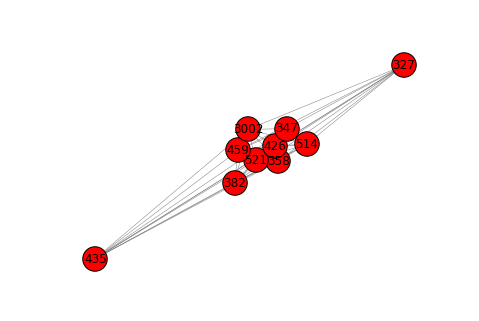

In [33]:
wd0_top = topdict2(nx.pagerank(weekday_graph0, 0.85), 10)
print wd0_top
wd_gr0 = weekday_graph0.subgraph(wd0_top)
print wd_gr0.nodes()
random.seed(2015)
nx.draw(wd_gr0, with_labels=True, arrows=True, node_color='red', width=0.5, edge_color='gray', node_size = 0.6e3)

In [34]:
# Calculating pageranks for each community inside each community
print "Week Day community 0"
topdict(nx.pagerank(weekday_graph0, 0.85), 10)
print "\n"
print "WeekEnd community 0"
topdict(nx.pagerank(weekend_graph0, 0.85), 10)
print "\n\n"
print "Week Day community 1"
topdict(nx.pagerank(weekday_graph1, 0.85), 10)
print "\n"
print "WeekEnd community 1"
topdict(nx.pagerank(weekend_graph1, 0.85), 10)
print "\n\n"
print "Week Day community 2"
topdict(nx.pagerank(weekday_graph2, 0.85), 10)
print "\n"
print "Week Day community 2"
topdict(nx.pagerank(weekend_graph2, 0.85), 10)
print "\n\n"
print "Week Day community 3"
topdict(nx.pagerank(weekday_graph3, 0.85), 10)
print "\n"
print "WeekEnd community 3"
topdict(nx.pagerank(weekend_graph3, 0.85), 10)

Week Day community 0
1|426:0.0530289404651 West St & Chambers St
2|358:0.0423519794448 Christopher St & Greenwich St
3|521:0.0420688830635 8 Ave & W 31 St
4|327:0.0340917919292 Vesey Pl & River Terrace
5|347:0.0336529890598 W Houston St & Hudson St
6|3002:0.0304918568539 South End Ave & Liberty St
7|514:0.028294824227 12 Ave & W 40 St
8|459:0.0270832088553 W 20 St & 11 Ave
9|382:0.0234417352173 University Pl & E 14 St
10|435:0.0224954726778 W 21 St & 6 Ave


WeekEnd community 0
1|499:0.0343593846524 Broadway & W 60 St
2|281:0.0282919464331 Grand Army Plaza & Central Park S
3|2006:0.0241670805138 Central Park S & 6 Ave
4|497:0.0239049011758 E 17 St & Broadway
5|457:0.0231440413828 Broadway & W 58 St
6|444:0.0185016740521 Broadway & W 24 St
7|305:0.0169705359988 E 58 St & 3 Ave
8|435:0.0160966124252 W 21 St & 6 Ave
9|521:0.0152913329165 8 Ave & W 31 St
10|528:0.0147913460673 2 Ave & E 31 St



Week Day community 1
1|519:0.0340523328574 E 42 St & Vanderbilt Ave
2|492:0.0214347637111 W 33 